# Autoencoders

For Colab, it downloads the data using the following code. 

If you work locally be sure to have the folder *data/*. You can download it from the repo.

In [1]:
try:
  from google.colab import files
  !wget -q https://github.com/Amelrich/Capstone-Fall-2020/archive/master.zip
  !unzip -q master.zip
  !rm -rf data
  !mv Capstone-Fall-2020-master/data/ data/
  !mv Capstone-Fall-2020-master/TS_utils.py /content/
  !rm -rf master.zip Capstone-Fall-2020-master/
except:
  print("only in Colab")

In [2]:
!pip -q install -U yellowbrick
!pip -q install scikit-learn-extra

     |████████████████████████████████| 276kB 6.0MB/s 
     |████████████████████████████████| 624kB 5.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from TS_utils import TS_generator, Synthetic_TS_generator
from TS_utils import MedianScaler, DCT_lowpass_filter
from TS_utils import KMedians

# **Autoencoders**

In [4]:
import tensorflow as tf
import keras
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, InputLayer
import keras.regularizers as reg
from keras.optimizers import Adam

## Model

In [5]:
class Autoencoder:
    def __init__(self, time_step, n_features=1):
        self.encoder = Sequential()
        self.encoder.add(Dense(20, input_shape=(time_step,)))
                               #kernel_regularizer=reg.l1(0.001),
                               #bias_regularizer=reg.l1(0.001),
                               #activity_regularizer=reg.l1(0.001)) )
        #self.encoder.add(LSTM(10, input_shape=(time_step, n_features), return_sequences=True))
        #self.encoder.add(LSTM(20))

        self.decoder = Sequential()
        #self.decoder.add(Dense(40, activation='relu'))
        self.decoder.add(Dense(time_step))

        self.autoencoder = Model( self.encoder.input, self.decoder(self.encoder.output) )
        self.encoding_model = Model( self.encoder.input, self.encoder.output )

        opt = Adam(learning_rate=0.005)
        self.autoencoder.compile(optimizer=opt, loss='mse')
        print(self.autoencoder.summary())
        #print(self.encoding_model.summary())

    def fit(self, X_train, X_test, epochs=50, verbose=1):
        self.autoencoder.fit(X_train, X_train, batch_size=16, epochs=epochs, shuffle=True,
                             verbose=verbose, validation_data=(X_test, X_test))

    def encode(self, x):
        return self.encoding_model.predict(x)

    def predict(self, x):
        return self.autoencoder.predict(x)


## Preprocess and Train

In [102]:
#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

SYNTHETIC = True
n_ts = 1000

if SYNTHETIC:
  gen = Synthetic_TS_generator(nb_timeseries=2*n_ts, chunk_size=60, noise=False)
  #gen.noise_freq_range = (20,30)
  #gen.build_()
  X = gen.get_array()

  scaler = StandardScaler()
  #scaler = MinMaxScaler()
  #scaler = MedianScaler()

  Xscale = scaler.fit_transform(X.T).T
  X_train, X_val = Xscale[:n_ts,:], Xscale[n_ts:,:]
  X_val_mm = (MinMaxScaler().fit_transform(X.T).T)[n_ts:,:]

else:
  gen = TS_generator(nb_timeseries=2*n_ts, chunk_size=60)
  X = gen.get_array()

  lowpass_filter = DCT_lowpass_filter()
  scaler = StandardScaler()
  scaler = MinMaxScaler()
  #scaler = MedianScaler()

  Xdct = lowpass_filter.fit_transform(X)
  Xscale = scaler.fit_transform(Xdct.T).T

  X_train, X_val = Xscale[:n_ts,:], Xscale[n_ts:,:]
  X_val_mm = (MinMaxScaler().fit_transform(Xdct.T).T)[n_ts:,:]

In [103]:
model = Autoencoder(time_step=60)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6_input (InputLayer)   [(None, 60)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1220      
_________________________________________________________________
sequential_7 (Sequential)    (None, 60)                1260      
Total params: 2,480
Trainable params: 2,480
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
model.fit(X_train, X_val, epochs=100, verbose=1)

Epoch 1/100
63/63 [==============================] - 0s 3ms/step - loss: 0.2687 - val_loss: 0.0076
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 1.2071e-05
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 2.0325e-06 - val_loss: 2.7747e-08
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 4.5891e-09 - val_loss: 5.6013e-11
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 1.3161e-11 - val_loss: 5.1927e-13
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 1.2354e-13 - val_loss: 3.4686e-14
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 2.3875e-14 - val_loss: 2.3551e-14
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 2.2458e-14 - val_loss: 2.3807e-14
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 2.3220e-14 - val_loss: 2.0782e-14
Epoch 10/100
63/63 [=============================

## Visualization of the training

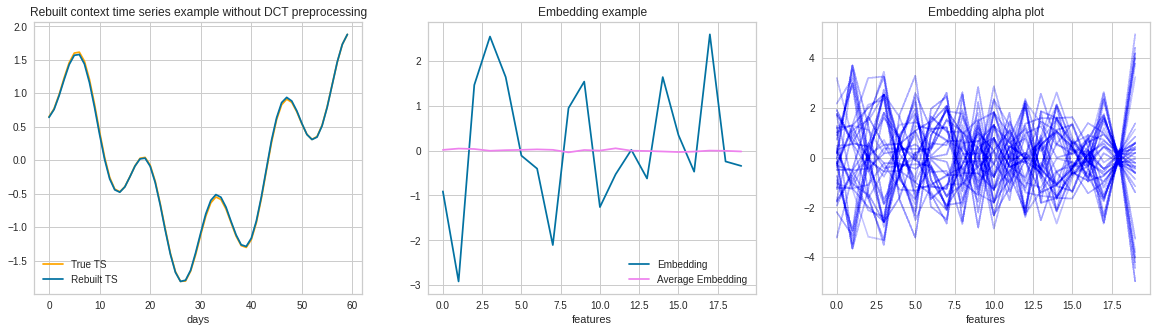

In [105]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

idx = 0
x_emb = model.encode(X_val[idx,:].reshape(1,60))[0]
x_rebuilt = model.predict(X_val[idx,:].reshape(1,60))[0]
mean_emb = model.encode(X_val).mean(axis=0)

ax[0].plot(X_val[idx,:], c='orange', label='True TS')
ax[0].plot(x_rebuilt, label='Rebuilt TS')
ax[0].set_xlabel('days')
ax[0].set_title('Rebuilt context time series example without DCT preprocessing')
ax[0].legend()

ax[1].plot(x_emb, label='Embedding')
ax[1].plot(mean_emb, c='violet', label='Average Embedding')
ax[1].set_xlabel('features')
ax[1].set_title('Embedding example')
ax[1].legend()

x_emb = model.encode(X_val)
for i in range(len(X_val)):
    ax[2].plot(x_emb[i,:], alpha=0.01, c='blue')

ax[2].set_xlabel('features')
ax[2].set_title('Embedding alpha plot')

plt.show()

# Clustering

In [106]:
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from collections import Counter

In [107]:
if SYNTHETIC:
  mean = X[n_ts:].mean(axis=1)
  std =  X[n_ts:].std(axis=1)
  med = np.median(X[n_ts:], axis=1)
  mad = np.median(np.abs(X[n_ts:].T - med).T, axis=1)
else:
  mean = Xdct[n_ts:].mean(axis=1)
  std =  Xdct[n_ts:].std(axis=1)
  med = np.median(Xdct[n_ts:], axis=1)
  mad = np.median(np.abs(Xdct[n_ts:].T - med).T, axis=1)

embedding = model.encode(X_val)
#embedding = ((embedding.T * std) + mean).T
#embedding = (embedding.T * mad) + med
embedding = MinMaxScaler().fit_transform(embedding.T).T
embedding.shape

(1000, 20)

In [108]:
X_cluster = np.concatenate([X_val_mm[:,40:], embedding], axis=1)
#X_cluster = np.concatenate([X_val[:,40:], embedding], axis=1)
X_cluster.shape

(1000, 40)

In [109]:
cl = KMeans(n_clusters=10)
#cl = KMedians(n_clusters=10)
#cl = KMedoids(n_clusters=10, metric='cosine')
y_train_pred = cl.fit_predict(X_cluster)

In [110]:
def visualizer(X_vis, labels, title, xlabel='days'):
  lines = (len(np.unique(y_train_pred)) - 1) // 5 + 1

  fig, ax = plt.subplots(lines, 5, figsize=(22, 5*lines))
  fig.suptitle(title)

  for j in range(5):
    for i in range(lines):
      indices = [k for k,label in enumerate(labels) if label == j + (5*i)]
      #print(indices)
      X_center = np.median(X_vis[indices,:], axis=0)
      for idx in indices:
        ax[i,j].plot(X_vis[idx,:], alpha=0.1, c='blue')
      ax[i,j].plot(X_center, c='orange', linewidth=4)
      ax[i,j].set_xlabel(xlabel)
      ax[i,j].set_title(f'Cluster {j + (5*i)} centroid (n={len(indices)})')

  plt.show()

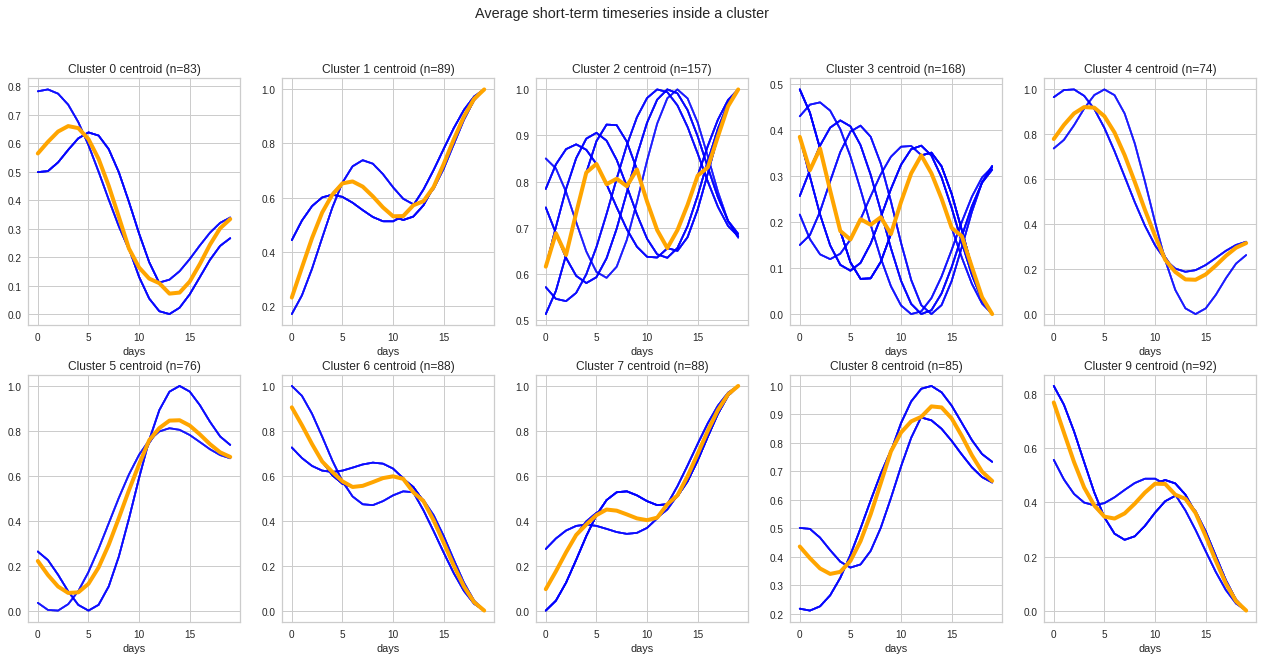

In [111]:
title = 'Average short-term timeseries inside a cluster'
visualizer(X_cluster[:,:20], y_train_pred, title=title)

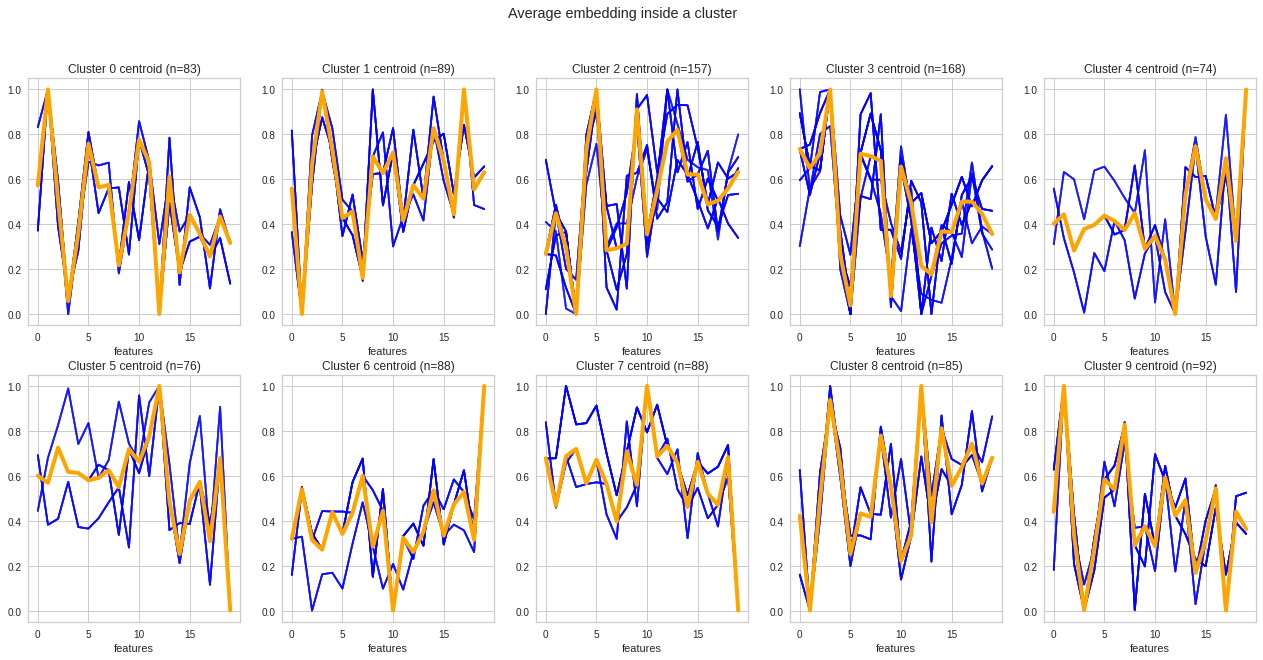

In [112]:
title = 'Average embedding inside a cluster'
visualizer(X_cluster[:,20:], y_train_pred, title=title, xlabel='features')

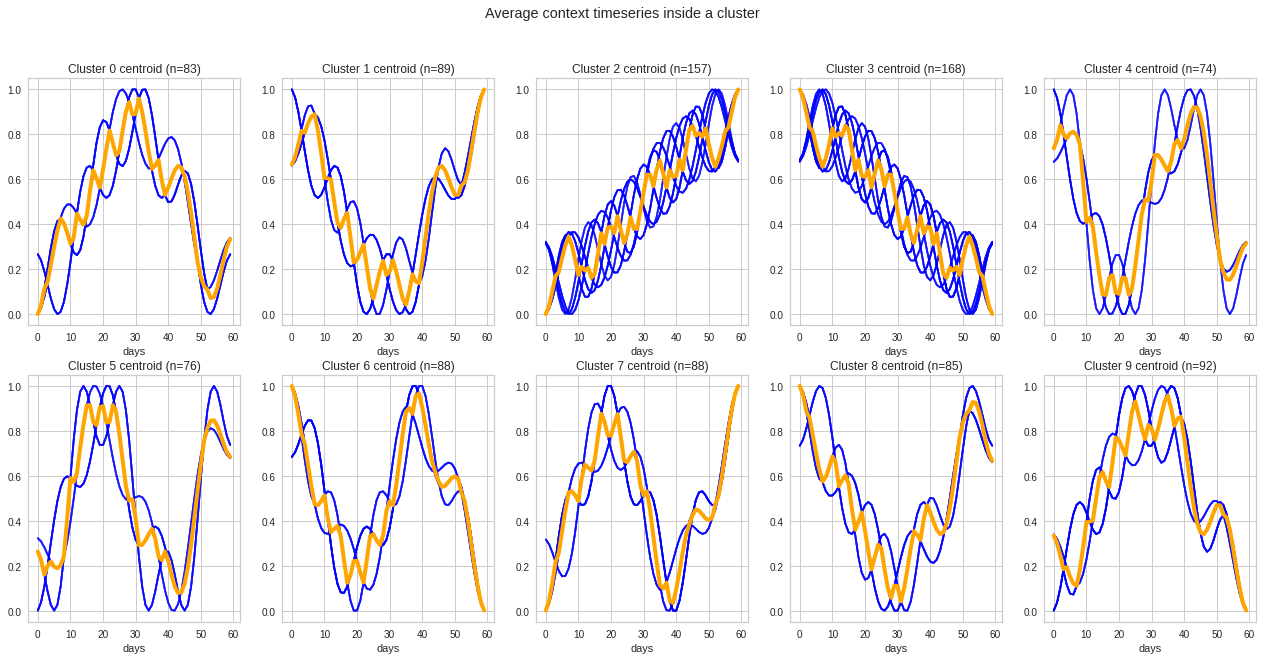

In [113]:
title = 'Average context timeseries inside a cluster'
visualizer(X_val_mm, y_train_pred, title=title)

## Silhouette score

In [114]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  "its corresponding cluster 

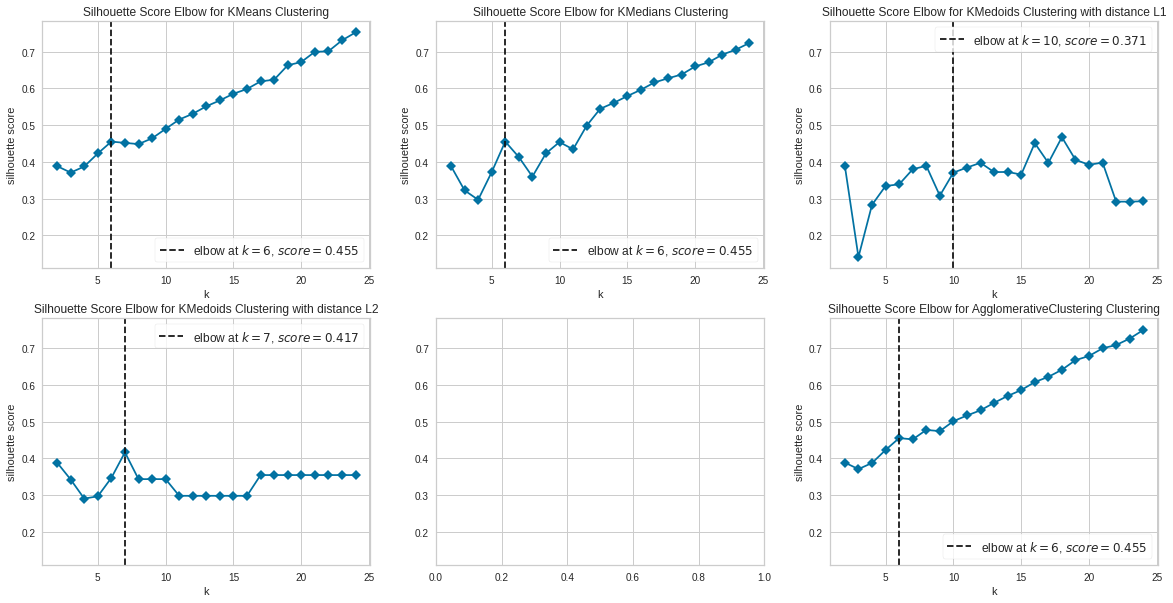

In [115]:
fig, ax = plt.subplots(2, 3, figsize=(20,10), sharey='all')
for a in fig.axes:
    a.tick_params(axis='y', which='both', left=True, labelleft=True)

title_medoid = 'Silhouette Score Elbow for KMedoids Clustering with distance '
metric='silhouette'

KElbowVisualizer(KMeans(), k=(2,25), metric=metric, ax=ax[0,0], timings=False).fit(X_cluster).finalize()
KElbowVisualizer(KMedians(), k=(2,25), metric=metric, ax=ax[0,1], timings=False).fit(X_cluster).finalize()
KElbowVisualizer(KMedoids(metric='l1'), k=(2,25), metric=metric, ax=ax[0,2], timings=False, title=title_medoid+'L1').fit(X_cluster).finalize()
KElbowVisualizer(KMedoids(metric='l2'), k=(2,25), metric=metric, ax=ax[1,0], timings=False, title=title_medoid+'L2').fit(X_cluster).finalize()
#KElbowVisualizer(KMedoids(metric='cosine'), k=(2,25), metric=metric, ax=ax[1,1], timings=False, title=title_medoid+'cosine').fit(X_cluster).finalize()
KElbowVisualizer(AgglomerativeClustering(), k=(2,25), metric=metric, ax=ax[1,2], timings=False).fit(X_cluster).finalize()

plt.show()

In [116]:
from sklearn.metrics import silhouette_score

cl=KMeans(n_clusters=6)
y_train_pred = cl.fit_predict(X_cluster)
silhouette_score(X_cluster, y_train_pred)

0.4553521869849309

In [117]:
score = []
silhouette = []
max_cluster=25

for k in range(2,max_cluster):
  cl = KMeans(n_clusters=k, init='random')
  y_train_pred = cl.fit_predict(X_cluster)
  silhouette.append( silhouette_score(X_cluster, y_train_pred) )
  score.append(cl.inertia_)

Text(0.5, 1.0, 'Silhouette score with KMeans')

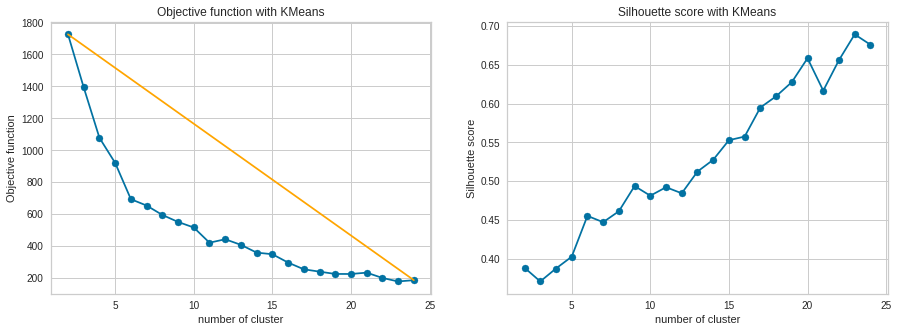

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(list(range(2,max_cluster)), score)
ax[0].scatter(list(range(2,max_cluster)), score)
ax[0].plot([2,max_cluster-1], [score[0], score[-1]], c='orange')
ax[0].set_xlabel('number of cluster')
ax[0].set_ylabel('Objective function')
ax[0].set_title(f'Objective function with KMeans')

ax[1].plot(list(range(2,max_cluster)), silhouette)
ax[1].scatter(list(range(2,max_cluster)), silhouette)
#ax[1].plot([2,max_cluster-1], [silhouette[0], silhouette[-1]], c='orange')
ax[1].set_xlabel('number of cluster')
ax[1].set_ylabel('Silhouette score')
ax[1].set_title(f'Silhouette score with KMeans')

In [119]:
def elbow(score_tab):
  a = (score_tab[-1] - score_tab[0]) / len(score_tab)
  b = score_tab[0]

  elb_tab = [ np.abs(score_tab[i] - a*i - b) / np.sqrt(a*a + 1) for i in range(len(score_tab)) ]
  return elb_tab.index(max(elb_tab))

In [120]:
print("Best k for KMeans with objective function:", elbow(score)+2)
print("Best k for KMeans with silhouette score:", elbow(silhouette)+2)

Best k for KMeans with objective function: 6
Best k for KMeans with silhouette score: 20


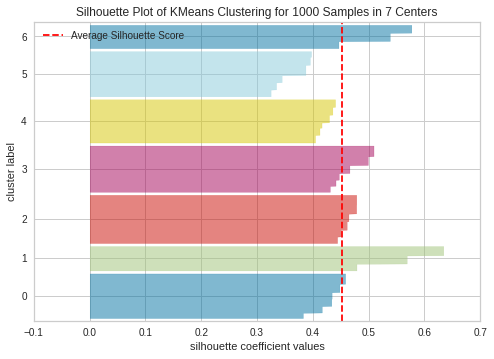

In [121]:
viz_model = KMedians(n_clusters=elbow(silhouette)+2)
viz_model = KMedoids(n_clusters=4, metric='cosine')
viz_model = KMeans(n_clusters=7)

visualizer = SilhouetteVisualizer(viz_model, colors='yellowbrick')
visualizer.fit(X_cluster) 
visualizer.show();

In [122]:
cl = KMedians(n_clusters=elbow(silhouette)+2)
y_train_pred = cl.fit_predict(X_cluster)
silhouette_score(X_cluster, y_train_pred)

0.6596394517009363

In [123]:
from sklearn.metrics import silhouette_samples

def sil_sample_cluster(data, col1, col2, thresh):
  '''
  computes the percentage of silhouette scores about a threshold within each cluster
  (input) data: DataFrame; col1: str refering to cluster column; col2: str refering to silhouette scores column; thresh: float between -1 and 1
  (output) ss_scores; dictionary
  '''
  ss_scores = {}
  for i in range(data[col1].nunique()):
    subs = data[data[col1]==i]
    ss_thresh = subs[subs[col2]>=thresh]
    ss_scores[i] = len(ss_thresh)/len(subs)
  
  return ss_scores

In [124]:
from sklearn.metrics import silhouette_samples

silhouette_scores = silhouette_samples(X_cluster, y_train_pred)

clusters_ss = pd.concat([pd.DataFrame(y_train_pred, columns= ['cluster']), pd.DataFrame(silhouette_scores, columns = ['silhouette_score'])], axis = 1)
clusters_ss.head() 

sil_sample_cluster(clusters_ss, 'cluster', 'silhouette_score', 0.5) #0 for all

{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 0.6941176470588235,
 7: 0.7108433734939759,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 0.7191011235955056,
 12: 1.0,
 13: 0.58,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0}

## PIP PE

In [125]:
!pip -q install python-fastpip

In [126]:
import numpy 
from fastpip import pip

## these are so help functions 

def reduce_dimension(context, dim):
    embed_matrix = np.empty(shape=[0, dim])
    # Going through each row of the context scale and reduce its dimension
    for i in range(context.shape[0]):
        x = np.arange(1, context.shape[1] + 1)  
        y = context[i,:]
        sample = [(a,b) for a, b in zip(x,y)]
        reduce_sample = pip(sample, dim)
        result = [a[1] for a in reduce_sample]
        
        embed_matrix = np.append(embed_matrix, np.asarray(result).reshape(1,-1), axis=0)
    return embed_matrix

def label_motif_general(window):
  s = window
  sort_index = numpy.argsort(s)
  sort_index = [1+i for i in sort_index]
  m='motif_'
  for i in sort_index:
    m = '{}{}'.format(m,i)
  return(m)

def motif_dictionary(x, n=3):
  dict_3_motifs ={}
  for perm in itertools.permutations([i for i in range(1,n+1)]):
    m='motif_' + ''.join(map(str,perm))
    dict_3_motifs[m] = 0

  # find the motifs and add them in a dictionary
  for i in x:
    label = label_motif_general(i)
    dict_3_motifs[label] = dict_3_motifs[label] + 1

  return dict_3_motifs


def transform_to_3_pip(A):
  size = 3
  step = 1
  A = [A[i : i + size] for i in range(0, len(A), step)]
  result = []
  for sub_x in A:
    if len(sub_x) < 3:
      continue
    result.append(sub_x)
  return result

def create_new_list(x):
  new = []
  for i in x:
    new.append(transform_to_3_pip(i))

  flat_list = [item for sublist in new for item in sublist]
  return flat_list

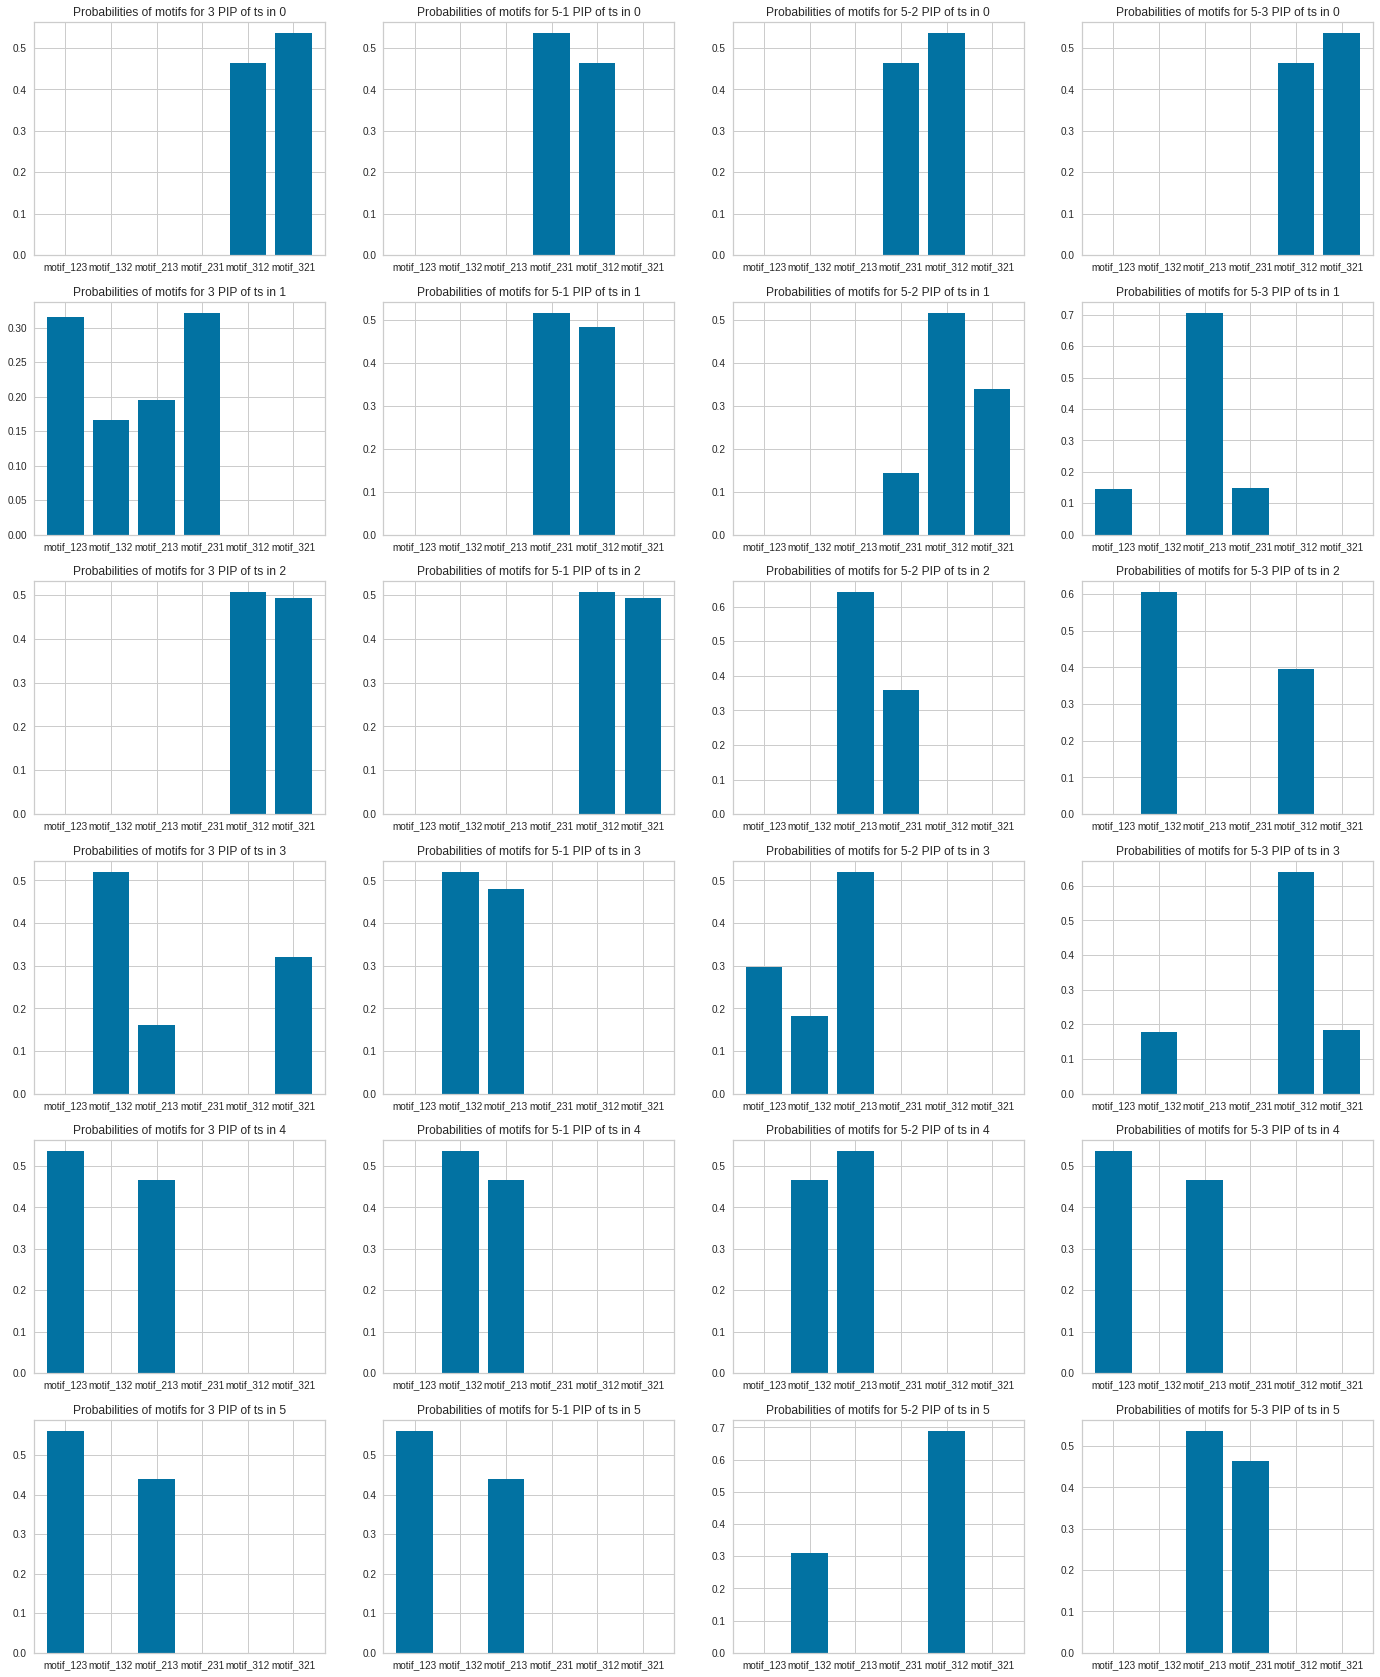

In [127]:
import collections

n_clusters = 6
cl = KMeans(n_clusters=n_clusters)
y_train_pred = cl.fit_predict(X_cluster)

ncols = 4
nrows = n_clusters
fig, ax = plt.subplots(nrows=n_clusters, ncols=4, figsize=(6*ncols, 5*nrows))

for cluster in range(n_clusters):
  indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
  
  # reduce dimentions of each ts to 3
  pip_3 = reduce_dimension(X_val[indices,:],3)
  # get 3 dim motifs count
  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_3).items()))
  ax[cluster,0].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,0].title.set_text('Probabilities of motifs for 3 PIP of ts in '+str(cluster))

  # reduce dimentions of each ts to 5
  pip_5 = reduce_dimension(np.array(X_val[indices,:]), 5)
  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_5[:,:3]).items()))
  ax[cluster,1].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,1].title.set_text('Probabilities of motifs for 5-1 PIP of ts in '+str(cluster))

  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_5[:,1:4]).items()))
  ax[cluster,2].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,2].title.set_text('Probabilities of motifs for 5-2 PIP of ts in '+str(cluster))

  dict_motifs = od = collections.OrderedDict(sorted(motif_dictionary(pip_5[:,2:]).items()))
  ax[cluster,3].bar(list(dict_motifs.keys()), np.array(list(dict_motifs.values())) / len(indices) )
  ax[cluster,3].title.set_text('Probabilities of motifs for 5-3 PIP of ts in '+str(cluster))